In [1]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile

import json
import pandas as pd

import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value

from sklearn.metrics import brier_score_loss, roc_auc_score
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
#VAEP functions are compatible with this version of the socceraction library only

#!pip install socceraction==0.2.0

In [2]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [3]:
data_files = {
    'events': 'https://ndownloader.figshare.com/files/14464685',  # ZIP file containing one JSON file for each competition
    'matches': 'https://ndownloader.figshare.com/files/14464622',  # ZIP file containing one JSON file for each competition
    'players': 'https://ndownloader.figshare.com/files/15073721',  # JSON file
    'teams': 'https://ndownloader.figshare.com/files/15073697'  # JSON file
}

In [4]:
for url in tqdm(data_files.values()):
    url_s3 = urlopen(url).geturl()
    path = Path(urlparse(url_s3).path)
    file_name = path.name
    file_local, _ = urlretrieve(url_s3, file_name)
    if is_zipfile(file_local):
        with ZipFile(file_local) as zip_file:
            zip_file.extractall()

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [6]:
json_teams = read_json_file('teams.json')
df_teams = pd.read_json(json_teams)

In [7]:
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')

In [8]:
json_players = read_json_file('players.json')
df_players = pd.read_json(json_players)

In [9]:
df_players.to_hdf('wyscout.h5', key='players', mode='a')

In [10]:
competitions = [
#   'England',
#     'France',
     'Germany',
#     'Italy',
#    'Spain',
#   'European Championship',
#   'World Cup'
]

In [11]:
dfs_matches = []
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
df_matches = pd.concat(dfs_matches)

In [12]:
df_matches.head(10)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405517,34,"{'2444': {'scoreET': 0, 'coachId': 14710, 'sid...",181137,2018-05-12 13:30:00,2445,Allianz Arena,2517036,"Bayern München - Stuttgart, 1 - 4","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 379444, 'role': 'referee'}, {'r...",Regular,426
1,Played,4405517,34,"{'2482': {'scoreET': 0, 'coachId': 272299, 'si...",181137,2018-05-12 13:30:00,2482,WIRSOL Rhein-Neckar-Arena,2517037,"Hoffenheim - Borussia Dortmund, 3 - 1","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 384936, 'role': 'referee'}, {'r...",Regular,426
2,Played,4405517,34,"{'2457': {'scoreET': 0, 'coachId': 18987, 'sid...",181137,2018-05-12 13:30:00,2975,Olympiastadion Berlin,2517038,"Hertha BSC - RB Leipzig, 2 - 6","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387276, 'role': 'referee'}, {'r...",Regular,426
3,Played,4405517,34,"{'2453': {'scoreET': 0, 'coachId': 14977, 'sid...",181137,2018-05-12 13:30:00,2453,Schwarzwald-Stadion,2517039,"Freiburg - Augsburg, 2 - 0","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 378957, 'role': 'referee'}, {'r...",Regular,426
4,Played,4405517,34,"{'2449': {'scoreET': 0, 'coachId': 447924, 'si...",181137,2018-05-12 13:30:00,2449,VELTINS-Arena,2517040,"Schalke 04 - Eintracht Frankfurt, 1 - 0","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387273, 'role': 'referee'}, {'r...",Regular,426
5,Played,4405517,34,"{'2455': {'scoreET': 0, 'coachId': 19925, 'sid...",181137,2018-05-12 13:30:00,2446,BayArena,2517041,"Bayer Leverkusen - Hannover 96, 3 - 2","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 381835, 'role': 'referee'}, {'r...",Regular,426
6,Played,4405517,34,"{'2454': {'scoreET': 0, 'coachId': 15114, 'sid...",181137,2018-05-12 13:30:00,2450,Volksparkstadion,2517042,"Hamburger SV - Borussia M'gladbach, 2 - 1","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 384898, 'role': 'referee'}, {'r...",Regular,426
7,Played,4405517,34,"{'2443': {'scoreET': 0, 'coachId': 367510, 'si...",181137,2018-05-12 13:30:00,2443,OPEL ARENA,2517043,"Mainz 05 - Werder Bremen, 1 - 2","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 378970, 'role': 'referee'}, {'r...",Regular,426
8,Played,4405517,34,"{'2451': {'scoreET': 0, 'coachId': 14735, 'sid...",181137,2018-05-12 13:30:00,2451,VOLKSWAGEN ARENA,2517044,"Wolfsburg - Köln, 4 - 1","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 459927, 'role': 'referee'}, {'r...",Regular,426
9,Played,4405517,33,"{'2460': {'scoreET': 0, 'coachId': 228372, 'si...",181137,2018-05-05 13:30:00,2460,Signal-Iduna-Park,2517027,"Borussia Dortmund - Mainz 05, 1 - 2","May 5, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 378945, 'role': 'referee'}, {'r...",Regular,426


In [13]:
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')

In [14]:
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

In [15]:
convert_to_spadl('wyscout.h5', 'spadl.h5')

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [00:29<00:00, 10.46game/s]


...Converting events to actions


100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [04:29<00:00,  1.14game/s]


In [16]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_actiontypes = pd.read_hdf('spadl.h5', key='actiontypes')
df_bodyparts = pd.read_hdf('spadl.h5', key='bodyparts')
df_results = pd.read_hdf('spadl.h5', key='results')

In [17]:
nb_prev_actions = 3

In [18]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

In [19]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
    dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])
    
    df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/306 [00:00<?, ?it/s]

In [20]:
functions_labels = [
    labels.scores,
    labels.concedes
]

In [21]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    df_labels = pd.concat([function(df_actions) for function in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/306 [00:00<?, ?it/s]

In [22]:
columns_features = features.feature_column_names(functions_features, nb_prev_actions=nb_prev_actions)

In [23]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    dfs_features.append(df_features[columns_features])
df_features = pd.concat(dfs_features).reset_index(drop=True)

  0%|          | 0/306 [00:00<?, ?it/s]

In [24]:
columns_labels = [
    'scores',
    'concedes'
]

In [25]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    dfs_labels.append(df_labels[columns_labels])
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

  0%|          | 0/306 [00:00<?, ?it/s]

In [26]:
%%time
models = {}
for column_labels in columns_labels:
    model = CatBoostClassifier(
        eval_metric='AUC')
    model.fit(df_features, df_labels[column_labels])
    models[column_labels] = model

Learning rate set to 0.131618
0:	total: 350ms	remaining: 5m 50s
1:	total: 526ms	remaining: 4m 22s
2:	total: 686ms	remaining: 3m 47s
3:	total: 867ms	remaining: 3m 35s
4:	total: 1.07s	remaining: 3m 32s
5:	total: 1.25s	remaining: 3m 26s
6:	total: 1.42s	remaining: 3m 20s
7:	total: 1.59s	remaining: 3m 16s
8:	total: 1.75s	remaining: 3m 13s
9:	total: 1.93s	remaining: 3m 10s
10:	total: 2.1s	remaining: 3m 8s
11:	total: 2.26s	remaining: 3m 6s
12:	total: 2.44s	remaining: 3m 5s
13:	total: 2.63s	remaining: 3m 5s
14:	total: 2.83s	remaining: 3m 5s
15:	total: 3s	remaining: 3m 4s
16:	total: 3.2s	remaining: 3m 5s
17:	total: 3.4s	remaining: 3m 5s
18:	total: 3.56s	remaining: 3m 3s
19:	total: 3.75s	remaining: 3m 4s
20:	total: 3.95s	remaining: 3m 4s
21:	total: 4.14s	remaining: 3m 3s
22:	total: 4.32s	remaining: 3m 3s
23:	total: 4.52s	remaining: 3m 3s
24:	total: 4.71s	remaining: 3m 3s
25:	total: 4.89s	remaining: 3m 3s
26:	total: 5.09s	remaining: 3m 3s
27:	total: 5.29s	remaining: 3m 3s
28:	total: 5.47s	remaini

In [27]:
dfs_predictions = {}
for column_labels in columns_labels:
    model = models[column_labels]
    probabilities = model.predict_proba(df_features)
    predictions = probabilities[:, 1]
    dfs_predictions[column_labels] = pd.Series(predictions)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [28]:
df_predictions.head(10)

,scores,concedes
0,0.003736,0.000373
1,0.004451,0.001150
2,0.004479,0.001739
3,0.005300,0.002135
4,0.010854,0.003196
5,0.012380,0.002800
6,0.007129,0.002666
7,0.004895,0.000935
8,0.007292,0.002620
9,0.005335,0.002177


In [29]:
dfs_game_ids = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    dfs_game_ids.append(df_actions['game_id'])
df_game_ids = pd.concat(dfs_game_ids, axis=0).astype('int').reset_index(drop=True)

  0%|          | 0/306 [00:00<?, ?it/s]

In [30]:
df_predictions = pd.concat([df_predictions, df_game_ids], axis=1)

In [31]:
df_predictions.head(10)

,scores,concedes,game_id
0,0.003736,0.000373,2517036
1,0.004451,0.001150,2517036
2,0.004479,0.001739,2517036
3,0.005300,0.002135,2517036
4,0.010854,0.003196,2517036
5,0.012380,0.002800,2517036
6,0.007129,0.002666,2517036
7,0.004895,0.000935,2517036
8,0.007292,0.002620,2517036
9,0.005335,0.002177,2517036


In [32]:
df_predictions_per_game = df_predictions.groupby('game_id')

In [33]:
for game_id, df_predictions in tqdm(df_predictions_per_game):
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions.h5', key=f'game_{game_id}')

  0%|          | 0/306 [00:00<?, ?it/s]

In [34]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [35]:
dfs_values = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )
    
    df_predictions = pd.read_hdf('predictions.h5', key=f'game_{game_id}')
    df_values = value(df_actions, df_predictions['scores'], df_predictions['concedes'])
    
    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

  0%|          | 0/306 [00:00<?, ?it/s]

In [36]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [37]:
df_values[
    ['short_name','team_name' , 'scores', 'concedes', 'offensive_value', 'defensive_value', 'vaep_value']
].head(10)

,short_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,K. Volland,TSV Bayer 04 Leverkusen,0.005414,0.000365,0.000000,-0.000000,0.000000
1,K. Bellarabi,TSV Bayer 04 Leverkusen,0.002502,0.000166,-0.002912,0.000198,-0.002714
2,S. Bender,TSV Bayer 04 Leverkusen,0.003300,0.000822,0.000798,-0.000656,0.000142
3,B. Leno,TSV Bayer 04 Leverkusen,0.003468,0.002370,0.000168,-0.001548,-0.001380
4,S. Bender,TSV Bayer 04 Leverkusen,0.004321,0.003810,0.000853,-0.001440,-0.000587
5,Wendell,TSV Bayer 04 Leverkusen,0.002633,0.007190,-0.001688,-0.003380,-0.005067
6,S. Bender,TSV Bayer 04 Leverkusen,0.003383,0.003940,0.000749,0.003250,0.004000
7,Wendell,TSV Bayer 04 Leverkusen,0.002212,0.010315,-0.001171,-0.006375,-0.007546
8,S. Rudy,FC Bayern München,0.014384,0.001304,0.004069,0.000907,0.004977
9,S. Rudy,FC Bayern München,0.013716,0.002552,-0.000668,-0.001248,-0.001916


In [38]:
df_values["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    df_values[["player_id","team_name", "vaep_value", "offensive_value", "defensive_value","count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)

In [39]:
# Add player names
playersR = playersR.merge(df_players[["player_id", "short_name"]], how="left")
playersR["player_name"] = playersR[["short_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
437,388267.0,L. Bailey,13.962640,14.504365,-0.541724,1537
302,146583.0,J. Brandt,12.668901,13.102413,-0.433512,1649
70,14817.0,R. Lewandowski,12.631173,12.624157,0.007016,955
93,14989.0,D. Caligiuri,11.790356,12.376494,-0.586138,2405
290,134397.0,S. Gnabry,11.682625,11.553690,0.128935,836
254,65180.0,M. Gregoritsch,11.532564,10.554107,0.978457,1076
261,70096.0,J. Rodríguez,11.482520,11.115647,0.366872,1851
259,69411.0,A. Kramarić,11.278065,11.636390,-0.358326,1268
118,15129.0,D. Didavi,10.515366,10.467541,0.047825,1308
131,15231.0,K. Volland,10.133749,9.900265,0.233483,1155


In [40]:
pg = pd.read_hdf('spadl.h5', "player_games")
pg = pg[pg.game_id.isin(df_games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1500] # at least two full games played

def round_two_places(val):
    return round(val, 4)

stats["vaep_rating"] = (stats.vaep_value * 90 / stats.minutes_played).apply(round_two_places)
stats["offensive_rating"] = (stats.offensive_value * 90 / stats.minutes_played).apply(round_two_places)
stats["defensive_rating"] = (stats.defensive_value * 90 / stats.minutes_played).apply(round_two_places)
stats.sort_values("vaep_rating",ascending = False)

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
289,134397.0,S. Gnabry,11.682625,11.553690,0.128935,836,1534.906306,0.6850,0.6775,0.0076
260,70096.0,J. Rodríguez,11.482520,11.115647,0.366872,1851,1658.881321,0.6230,0.6031,0.0199
435,388267.0,L. Bailey,13.962640,14.504365,-0.541724,1537,2285.261963,0.5499,0.5712,-0.0213
38,14727.0,A. Robben,8.926481,8.955681,-0.029200,1209,1543.845730,0.5204,0.5221,-0.0017
69,14817.0,R. Lewandowski,12.631173,12.624157,0.007016,955,2231.048224,0.5095,0.5093,0.0003
...,...,...,...,...,...,...,...,...,...,...
291,134708.0,D. Origi,0.492771,0.580765,-0.087994,726,2040.552167,0.0217,0.0256,-0.0039
247,56274.0,Y. Poulsen,-0.052156,0.765583,-0.817739,782,1726.438714,-0.0027,0.0399,-0.0426
217,26021.0,S. Falette,-0.079822,2.527228,-2.607051,1585,2322.996577,-0.0031,0.0979,-0.1010
198,19720.0,M. Gulde,-0.904111,0.651756,-1.555867,976,1584.515670,-0.0514,0.0370,-0.0884


In [41]:
stats.to_csv('rankingBL.csv', index=False)

In [42]:
playersR.to_csv('rankingBL.csv', index=False)

In [43]:
print(df_values['team_name'].unique())

['TSV Bayer 04 Leverkusen' 'FC Bayern München' 'SV Werder Bremen'
 'TSG 1899 Hoffenheim' 'Hertha BSC' 'VfB Stuttgart 1893' 'SC Freiburg'
 'Eintracht Frankfurt' 'Borussia VfL Mönchengladbach' '1. FC Köln'
 'FC Schalke 04' 'Rasen Ballsport Leipzig' 'FC Augsburg' 'Hamburger SV'
 'Hannover 96' '1. FSV Mainz 05' 'BV Borussia 09 Dortmund' 'VfL Wolfsburg']


In [44]:
WB_teamBL =df_values[(df_values["team_name"]== "FC Schalke 04" ) | (df_values["team_name"]== "Eintracht Frankfurt" )| (df_values["team_name"]== "TSG 1899 Hoffenheim" )]

In [45]:
WB_teamBL

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,...,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
1337,2516740.0,1.0,19.124292,2482.0,49997.0,65.10,61.20,38.85,43.52,0,...,Zuber,1991-08-17,Hoffenheim,TSG 1899 Hoffenheim,0.005714,0.001065,-0.012902,0.000740,-0.012162,1
1338,2516740.0,1.0,22.876526,2482.0,14842.0,38.85,43.52,43.05,58.48,0,...,Vogt,1991-09-23,Hoffenheim,TSG 1899 Hoffenheim,0.005561,0.001440,-0.000153,-0.000375,-0.000528,1
1339,2516740.0,1.0,24.398820,2482.0,15719.0,43.05,58.48,44.10,46.24,0,...,Hübner,1989-07-04,Hoffenheim,TSG 1899 Hoffenheim,0.007806,0.001394,0.002244,0.000046,0.002290,1
1340,2516740.0,1.0,27.339055,2482.0,14842.0,44.10,46.24,55.65,38.08,0,...,Vogt,1991-09-23,Hoffenheim,TSG 1899 Hoffenheim,0.015706,0.002058,0.007900,-0.000664,0.007236,1
1341,2516740.0,1.0,29.514744,2482.0,367621.0,55.65,38.08,39.90,36.72,0,...,Geiger,1998-06-10,Hoffenheim,TSG 1899 Hoffenheim,0.010607,0.001800,-0.005099,0.000258,-0.004841,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384993,2517040.0,2.0,2803.139925,2462.0,4509.0,52.50,37.40,33.60,42.84,0,...,Mascarell González,1993-02-02,Eintracht Frankfurt,Eintracht Frankfurt,0.030988,0.003503,0.016816,0.000652,0.017468,1
384994,2517040.0,2.0,2804.172033,2462.0,20402.0,33.60,42.84,19.95,51.68,0,...,Boateng,1987-03-06,Eintracht Frankfurt,Eintracht Frankfurt,0.011608,0.005471,-0.019381,-0.001968,-0.021349,1
384995,2517040.0,2.0,2806.419781,2449.0,216077.0,19.95,51.68,42.00,51.68,0,...,Baba,1994-07-02,Schalke 04,FC Schalke 04,0.008357,0.005183,0.002886,0.006424,0.009310,1
384996,2517040.0,2.0,2810.492448,2462.0,69616.0,42.00,51.68,42.00,51.68,0,...,Rebić,1993-09-21,Eintracht Frankfurt,Eintracht Frankfurt,0.002931,0.011616,-0.002252,-0.003260,-0.005511,1


In [46]:
print(WB_teamBL['short_name'].unique().tolist())

['S. Zuber', 'K. Vogt', 'B. Hübner', 'D. Geiger', 'H. Nordtveit', 'J. Toljan', 'N. Amiri', 'K. Demirbay', nan, 'M. Uth', 'Á. Szalai', 'O. Baumann', 'A. Kramarić', 'S. Gnabry', 'E. Polanski', 'D. Abraham', 'S. Falette', 'T. Chandler', 'D. Kamada', 'J. Willems', 'M. Gaćinović', 'G. Fernandes', 'L. Hradecky', 'J. de Guzmán', 'S. Haller', 'M. Hasebe', 'K. Boateng', 'D. da Costa', 'B. Hrgota', 'F. Di Santo', 'Naldo', 'R. Fährmann', 'T. Kehrer', 'L. Goretzka', 'D. Caligiuri', 'A. Harit', 'M. Nastasić', 'B. Oczipka', 'N. Bentaleb', 'Y. Konoplyanka', 'F. Reese', 'W. McKennie', 'M. Meyer', 'T. Tawatha', 'S. Wagner', 'E. Bičakčić', 'L. Rupp', 'P. Kadeřábek', 'F. Grillitsch', 'G. Burgstaller', 'N. Schulz', 'P. Ochs', 'C. Salcedo', 'A. Rebić', 'M. Russ', 'B. Stambouli', 'F. Passlack', 'B. Embolo', 'L. Jović', 'M. Wolf', 'R. Hack', 'M. Stendera', 'S. Medojević', 'S. Posch', 'A. Schöpf', 'A. Barkok', 'Coke', 'K. Akpoguma', 'D. Blum', 'M. Pjaca', 'Omar Mascarell', 'R. Zulj', 'M. Fabián', 'Pablo Ínsua

In [47]:
WBSBL = stats[ (stats["player_name"]== "P. Kadeřábek" ) |(stats["player_name"]== "N. Schulz" )  | (stats["player_name"]== "J. Willems" )|(stats["player_name"]== "M. Wolf" )  | (stats["player_name"]== "T. Chandler" )| (stats["player_name"]== "D. Caligiuri" ) | (stats["player_name"]== "B. Oczipka" ) ] 
WBSBL

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
2,110.0,J. Willems,2.899526,4.432134,-1.532608,1197,1713.417920,0.1523,0.2328,-0.0805
53,14775.0,B. Oczipka,3.728785,6.293926,-2.565141,1817,2419.905811,0.1387,0.2341,-0.0954
92,14989.0,D. Caligiuri,11.790356,12.376494,-0.586138,2405,3041.291753,0.3489,0.3663,-0.0173
119,15139.0,T. Chandler,4.048326,4.271362,-0.223036,1162,1970.568442,0.1849,0.1951,-0.0102
195,18982.0,N. Schulz,4.846265,4.463925,0.382340,1387,1848.960339,0.2359,0.2173,0.0186
264,82487.0,P. Kadeřábek,3.828571,3.622212,0.206359,1427,2275.951755,0.1514,0.1432,0.0082
330,224680.0,M. Wolf,9.260850,9.416437,-0.155587,1459,2443.988811,0.3410,0.3468,-0.0057


In [48]:
FB_teamBL =df_values[(df_values["team_name"]== "TSV Bayer 04 Leverkusen" ) |(df_values["team_name"]== "FC Bayern München" )|(df_values["team_name"]== "SV Werder Bremen" ) |(df_values["team_name"]== "Hertha BSC" ) |(df_values["team_name"]== "VfB Stuttgart 1893" ) |(df_values["team_name"]== "SC Freiburg" ) |(df_values["team_name"]== "Borussia VfL Mönchengladbach" ) |(df_values["team_name"]== "1. FC Köln" ) |(df_values["team_name"]== "Rasen Ballsport Leipzig" ) |(df_values["team_name"]== "FC Augsburg" ) |(df_values["team_name"]== "Hamburger SV" ) |(df_values["team_name"]== "Hannover 96" ) | (df_values["team_name"]== "1. FSV Mainz 05" ) | (df_values["team_name"]== "BV Borussia 09 Dortmund" )| (df_values["team_name"]== "VfL Wolfsburg" ) ]
FB_teamBL

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,...,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
0,2516739.0,1.0,2.409746,2446.0,15231.0,52.50,34.00,52.50,32.64,0,...,Volland,1992-07-30,Bayer Leverkusen,TSV Bayer 04 Leverkusen,0.005414,0.000365,0.000000,-0.000000,0.000000,1
1,2516739.0,1.0,2.506082,2446.0,14786.0,52.50,32.64,81.90,14.96,0,...,Bellarabi,1990-04-08,Bayer Leverkusen,TSV Bayer 04 Leverkusen,0.002502,0.000166,-0.002912,0.000198,-0.002714,1
2,2516739.0,1.0,6.946706,2446.0,14803.0,81.90,14.96,98.70,31.28,0,...,Bender,1989-04-27,Bayer Leverkusen,TSV Bayer 04 Leverkusen,0.003300,0.000822,0.000798,-0.000656,0.000142,1
3,2516739.0,1.0,10.786491,2446.0,14768.0,98.70,31.28,84.00,6.80,0,...,Leno,1992-03-04,Bayer Leverkusen,TSV Bayer 04 Leverkusen,0.003468,0.002370,0.000168,-0.001548,-0.001380,1
4,2516739.0,1.0,12.684514,2446.0,14803.0,84.00,6.80,76.65,2.72,0,...,Bender,1989-04-27,Bayer Leverkusen,TSV Bayer 04 Leverkusen,0.004321,0.003810,0.000853,-0.001440,-0.000587,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389988,2517044.0,2.0,2817.761761,2463.0,94831.0,17.85,31.28,17.85,31.28,0,...,Ōsako,1990-05-18,Köln,1. FC Köln,0.006986,0.001041,0.002721,0.015096,0.017817,1
389989,2517044.0,2.0,2818.280436,2451.0,14917.0,17.85,31.96,23.10,27.20,0,...,Knoche,1992-05-22,Wolfsburg,VfL Wolfsburg,0.005872,0.011370,0.004831,-0.004383,0.000447,1
389990,2517044.0,2.0,2823.180681,2451.0,14804.0,23.10,27.20,0.00,3.40,0,...,Błaszczykowski,1985-12-14,Wolfsburg,VfL Wolfsburg,0.009028,0.001244,0.003156,0.010126,0.013283,1
389991,2517044.0,2.0,2828.080925,2451.0,14804.0,0.00,3.40,5.25,4.76,0,...,Błaszczykowski,1985-12-14,Wolfsburg,VfL Wolfsburg,0.000807,0.000629,-0.008221,0.000615,-0.007606,1


In [49]:
print(FB_teamBL['short_name'].unique().tolist())

['K. Volland', 'K. Bellarabi', 'S. Bender', 'B. Leno', 'Wendell', 'S. Rudy', 'T. Müller', 'C. Tolisso', 'C. Aránguiz', 'A. Vidal', 'J. Tah', 'N. Süle', 'D. Alaba', 'R. Lewandowski', 'J. Kimmich', 'F. Ribéry', 'A. Mehmedi', 'D. Kohr', 'L. Bailey', 'M. Hummels', 'S. Ulreich', 'B. Henrichs', nan, 'J. Brandt', 'A. Dragović', 'K. Kampl', 'Rafinha', 'A. Robben', 'K. Coman', 'M. Kruse', 'M. Eggestein', 'R. Bauer', 'F. Kainz', 'T. Delaney', 'L. Augustinsson', 'T. Gebre Selassie', 'J. Pavlenka', 'M. Veljkovic', 'L. Sané', 'F. Bartels', 'P. Bargfrede', 'J. Gondorf', 'A. Esswein', 'V. Darida', 'M. Kamiński', 'Ailton', 'P. Skjelbred', 'V. Ibišević', 'R. Zieler', 'S. Kalou', 'C. Gentner', 'T. Asano', 'M. Plattenhardt', 'K. Rekik', 'S. Langkamp', 'M. Weiser', 'B. Pavard', 'J. Brekalo', 'M. Leckie', 'M. Zimmermann', 'C. Akolo', 'S. Terodde', 'O. Mangala', 'R. Jarstein', 'D. Aogo', 'N. Stark', 'H. Badstuber', 'A. Donis', 'G. Haraguchi', 'J. Torunarigha', 'J. Haberer', 'C. Günter', 'J. Schuster', 'A. S

In [50]:
FBSBL = stats[(stats["player_name"]== "D. Alaba" )|(stats["player_name"]== "J. Kimmich" )|(stats["player_name"]== "Rafinha" )|(stats["player_name"]== "Ł. Piszczek" )  |(stats["player_name"]== "L. Klostermann" )    | (stats["player_name"]== "Wendell" )  | (stats["player_name"]== "L. Bender" ) | (stats["player_name"]== "O. Wendt" )    |(stats["player_name"]== "N. Elvedi" )   |(stats["player_name"]== "B. Pavard" )  |(stats["player_name"]== "A. Beck" )   |(stats["player_name"]== "P. Verhaegh" )  |(stats["player_name"]== "M. Plattenhardt" )  |(stats["player_name"]== "M. Weiser" )  |(stats["player_name"]== "V. Lazaro" )  |(stats["player_name"]== "T. Gebre Selassie" ) |(stats["player_name"]== "L. Augustinsson" ) |(stats["player_name"]== "P. Stenzel" ) |(stats["player_name"]== "C. Günter" ) |(stats["player_name"]== "P. Max" )    |(stats["player_name"]== "G. Donati" )  |(stats["player_name"]== "D. Brosinski" )   |(stats["player_name"]== "O. Sorg" ) |(stats["player_name"]== "M. Ostrzolek" )|(stats["player_name"]== "J. Hector" )|(stats["player_name"]== "Douglas Santos" )|(stats["player_name"]== "G. Sakai" )|(stats["player_name"]== "D. Diekmeier" ) ] 
FBSBL

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
35,14718.0,Rafinha,5.365260,5.469371,-0.104111,2052,1888.153238,0.2557,0.2607,-0.0050
36,14724.0,D. Alaba,3.102408,3.148997,-0.046590,1561,1600.919563,0.1744,0.1770,-0.0026
43,14749.0,G. Sakai,3.436011,3.326112,0.109899,1745,2362.879318,0.1309,0.1267,0.0042
55,14781.0,L. Bender,6.238171,5.443328,0.794843,1214,1637.153020,0.3429,0.2992,0.0437
61,14798.0,Ł. Piszczek,3.782355,2.854086,0.928269,1961,2210.662145,0.1540,0.1162,0.0378
81,14888.0,D. Diekmeier,4.749956,5.484035,-0.734078,1174,1939.925117,0.2204,0.2544,-0.0341
91,14988.0,O. Sorg,2.499793,1.933362,0.566432,1003,1737.042081,0.1295,0.1002,0.0293
98,15014.0,O. Wendt,3.019609,3.456930,-0.437321,1704,2531.042003,0.1074,0.1229,-0.0156
116,15125.0,M. Plattenhardt,9.651099,9.652323,-0.001224,2103,3082.424165,0.2818,0.2818,-0.0000
137,15276.0,M. Weiser,5.105327,5.236623,-0.131296,1590,2053.914688,0.2237,0.2295,-0.0058


In [51]:
Ax = WBSBL["offensive_rating"]
Ay = WBSBL["defensive_rating"]
Az = WBSBL["vaep_rating"]
Bx = FBSBL["offensive_rating"]
By = FBSBL["defensive_rating"]
Bz = FBSBL["vaep_rating"]

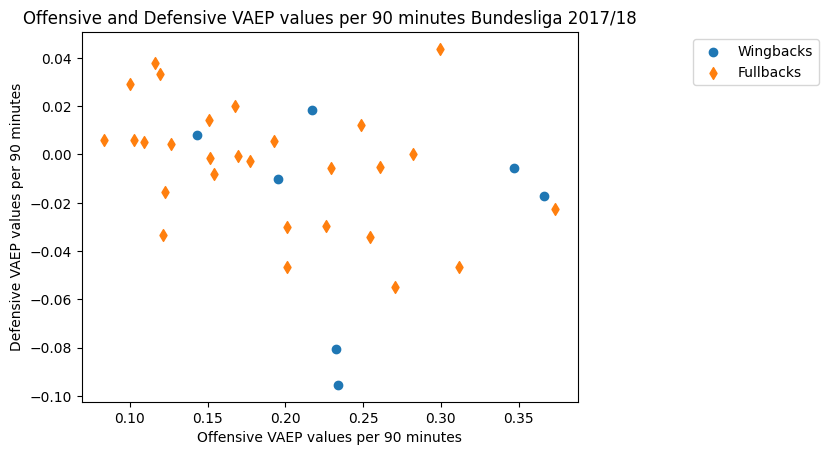

In [52]:
plt.title("Offensive and Defensive VAEP values per 90 minutes Bundesliga 2017/18")
plt.xlabel("Offensive VAEP values per 90 minutes") 
plt.ylabel("Defensive VAEP values per 90 minutes")
plt.scatter(Ax, Ay)
plt.scatter(Bx, By, marker="d")
plt.legend(["Wingbacks" , "Fullbacks"], bbox_to_anchor = (1.5 , 1))
plt.show()

In [53]:
#Wingbacks Offensive and Defensive average 

WB_Attacking_avg = WBSBL["offensive_rating"].mean()

WB_Defending_avg = WBSBL["defensive_rating"].mean()

WB_Total_avg = WB_Attacking_avg + WB_Defending_avg

In [54]:
WB_Attacking_avg

0.24794285714285716

In [55]:
WB_Defending_avg

-0.026042857142857145

In [56]:
WB_Total_avg

0.22190000000000001

In [57]:
#Fullbacks Offensive and Defensive average 

FB_Attacking_avg = FBSBL["offensive_rating"].mean()
FB_Defending_avg = FBSBL["defensive_rating"].mean()
FB_Total_avg = FB_Attacking_avg + FB_Defending_avg

In [58]:
FB_Attacking_avg

0.19013571428571427

In [59]:
FB_Defending_avg

-0.0042357142857142845

In [60]:
FB_Total_avg

0.18589999999999998

In [61]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Player position", "Total", "Offensive", "Defensive"])

# Add rows
myTable.add_row(["fullback", FB_Total_avg,FB_Attacking_avg,FB_Defending_avg])
myTable.add_row(["wingback", WB_Total_avg,WB_Attacking_avg,WB_Defending_avg])


print(myTable)

+-----------------+---------------------+---------------------+------------------------+
| Player position |        Total        |      Offensive      |       Defensive        |
+-----------------+---------------------+---------------------+------------------------+
|     fullback    | 0.18589999999999998 | 0.19013571428571427 | -0.0042357142857142845 |
|     wingback    | 0.22190000000000001 | 0.24794285714285716 | -0.026042857142857145  |
+-----------------+---------------------+---------------------+------------------------+


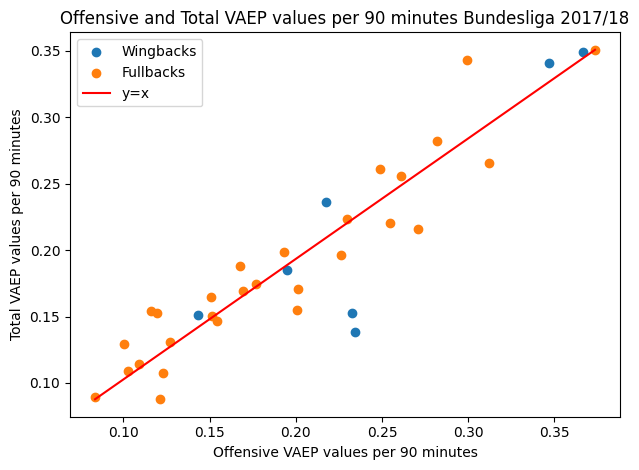

In [62]:
import matplotlib.pyplot as plt

plt.title("Offensive and Total VAEP values per 90 minutes Bundesliga 2017/18")
plt.xlabel("Offensive VAEP values per 90 minutes") 
plt.ylabel("Total VAEP values per 90 minutes")

plt.scatter(Ax, Az, label='Wingbacks')
plt.scatter(Bx, Bz, label='Fullbacks')

xmin = min(min(Ax), min(Bx))
xmax = max(max(Ax), max(Bx))
ymin = min(min(Az), min(Bz))
ymax = max(max(Az), max(Bz))

plt.plot([xmin, xmax], [ymin, ymax], color='red', label='y=x')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()